In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["font.size"] = 8

# Create xarray region mask

In this tutorial we will show how to create a mask for arbitrary latitude and longitude grids using xarray. It is very similar to the tutorial Create Mask (numpy).

Import regionmask and check the version:

In [2]:
import regionmask
regionmask.__version__

'0.9.0'

Load xarray and the tutorial data:

In [11]:
import xarray as xr
import numpy as np

In [5]:
airtemps = xr.tutorial.load_dataset('air_temperature')

The example data is a temperature field over North America. Let's plot the first time step:

/home/mathause/.local/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


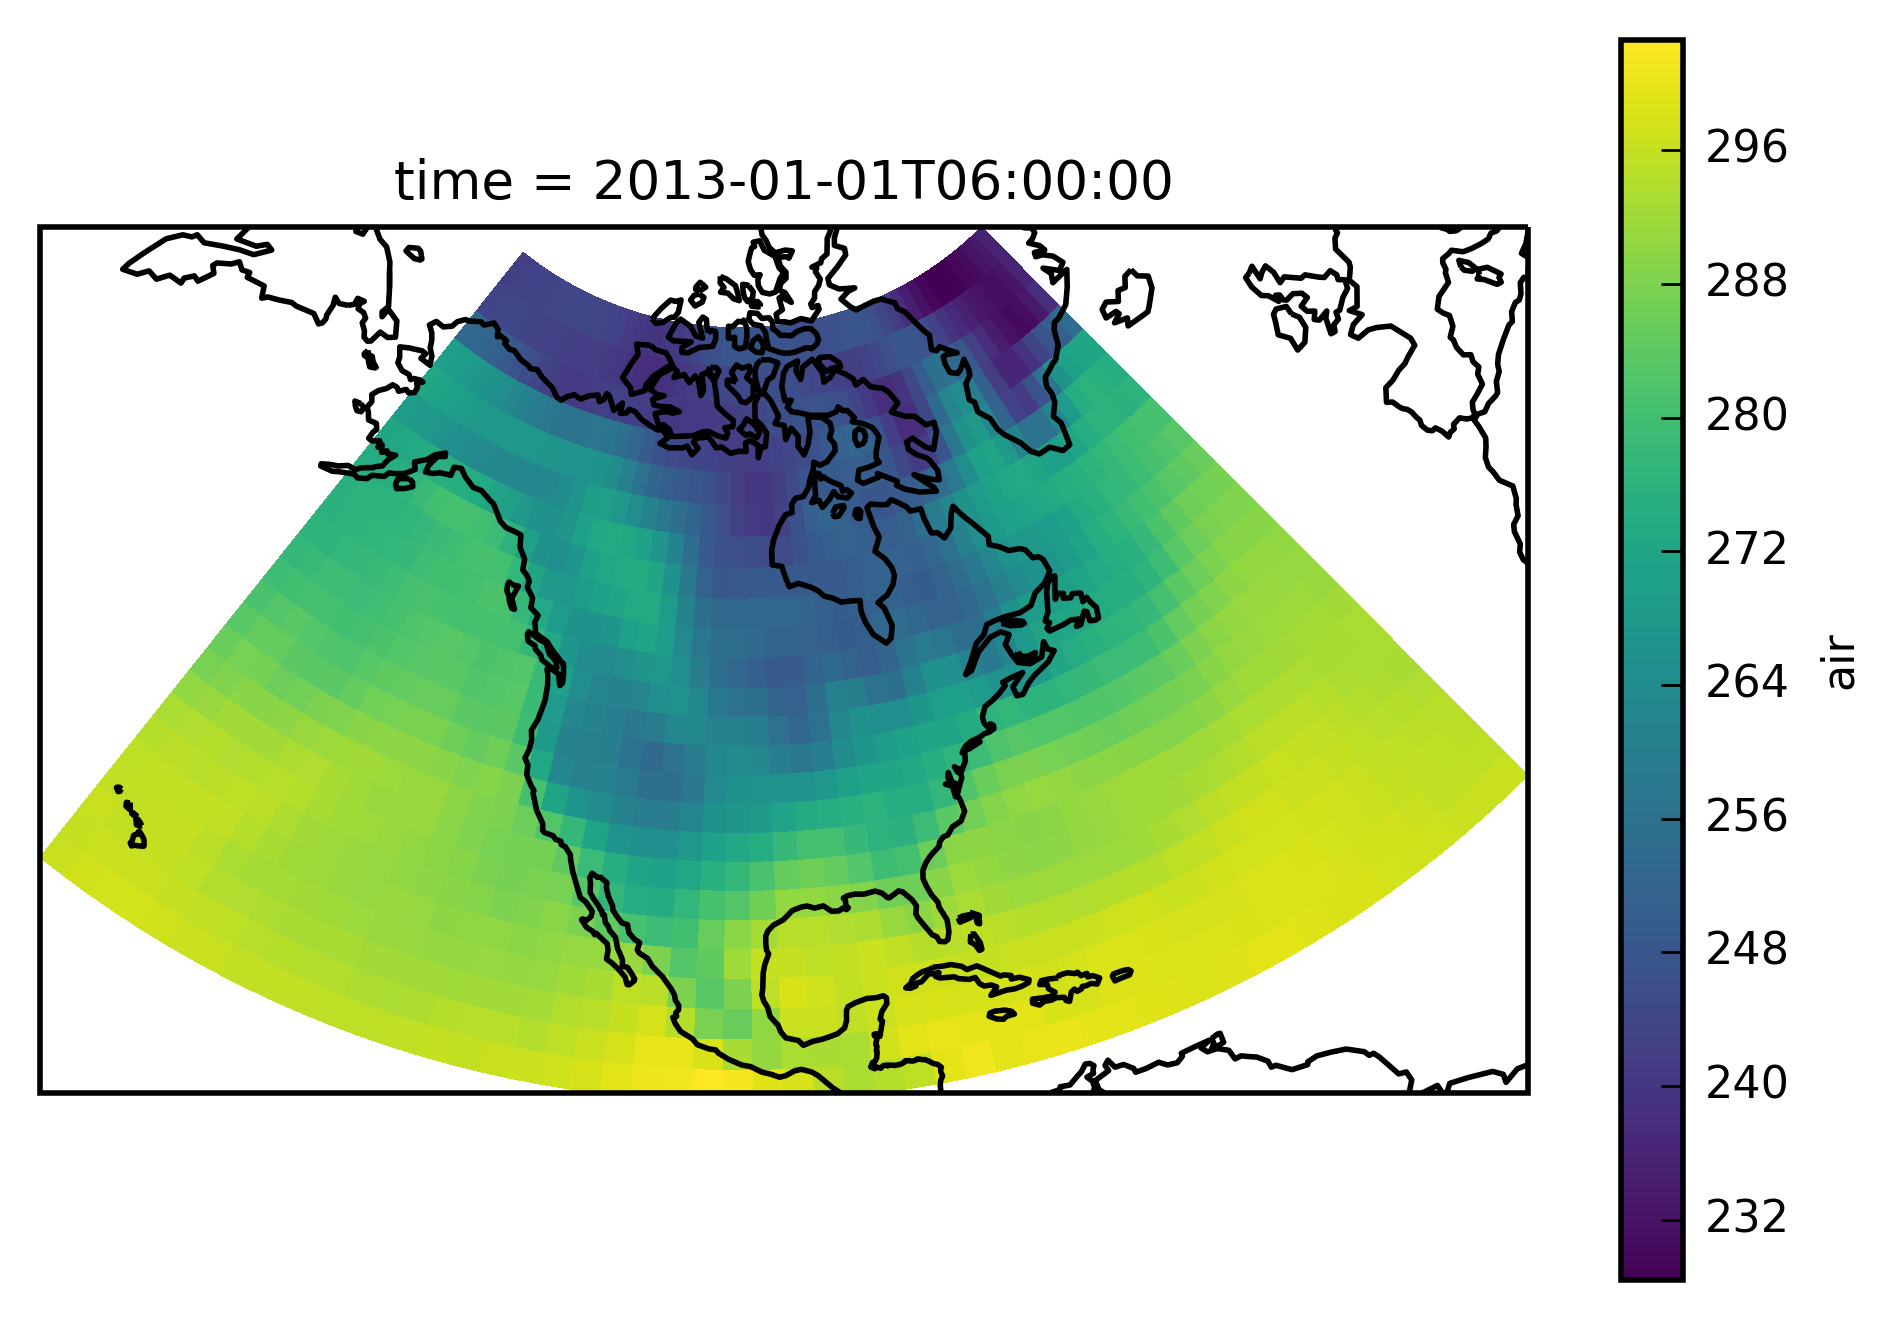

In [6]:
# load cartopy
import cartopy.crs as ccrs

# choose a good projection for regional maps
proj=ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

airtemps.isel(time=1).air.plot.geocolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

Conviniently we can directly pass an xarray object to the `mask` function. It gets the longitude and latitude from the DataArray/ Dataset and creates the `mask`. If the longituda and latitude in the xarray object are not called `lon` and `lat`, respectively; their name can be given via the `lon_name` and `lat_name` keyword. Here we use the Giorgi regions.

In [12]:
mask = regionmask.giorgi.mask(airtemps)
print('All NaN? ',np.all(np.isnan(mask)))

All elements of mask are NaN. Try to set 'wrap_lon=True'.
All NaN?  True


This didn't work - all elements are NaNs! The reason is that airtemps has its longitude from 0 to 360 while the Giorgi regions are defined as -180 to 180. Thus we can provide the `wrap_lon` keyword:

In [13]:
mask = regionmask.giorgi.mask(airtemps, wrap_lon=True)
print('All NaN? ',np.all(np.isnan(mask)))

All NaN?  False


This is better. Let's plot the regions:

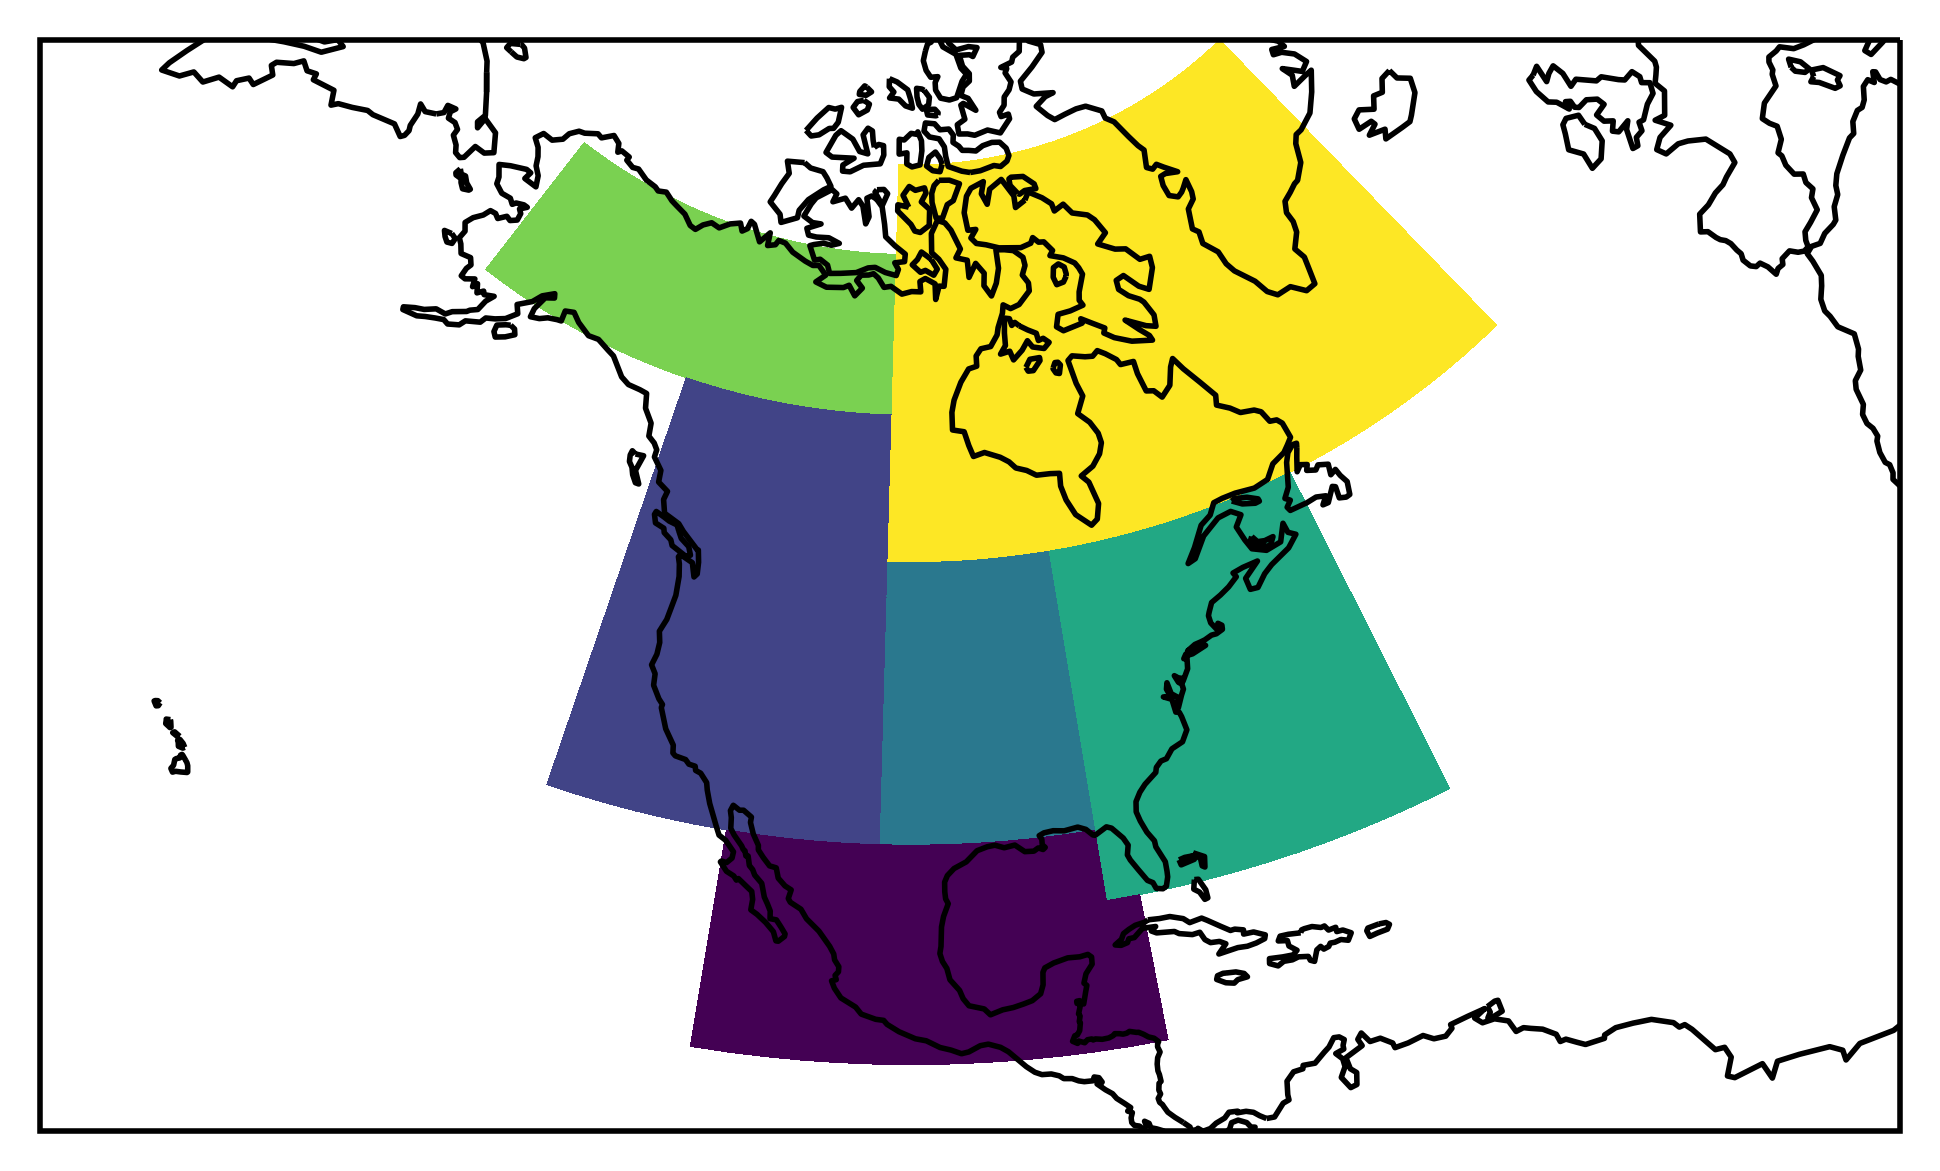

In [14]:
proj=ccrs.LambertConformal(central_longitude=-100)
ax = plt.subplot(111, projection=proj)

low = mask.min()
high = mask.max()

levels = np.arange(low - 0.5, high + 1)

mask.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), levels=levels, add_colorbar=False)

ax.coastlines()

# fine tune the extent
ax.set_extent([200, 330, 10, 75], crs=ccrs.PlateCarree());

We want to select the region 'Central North America'. Thus we first need to find out which number this is:

In [15]:
regionmask.giorgi.map_keys('Central North America')

6

`xarray` provides the handy `where` function:

In [16]:
airtemps_CNA = airtemps.where(mask == 6)

Check everything went well by repeating the first plot with the selected region:

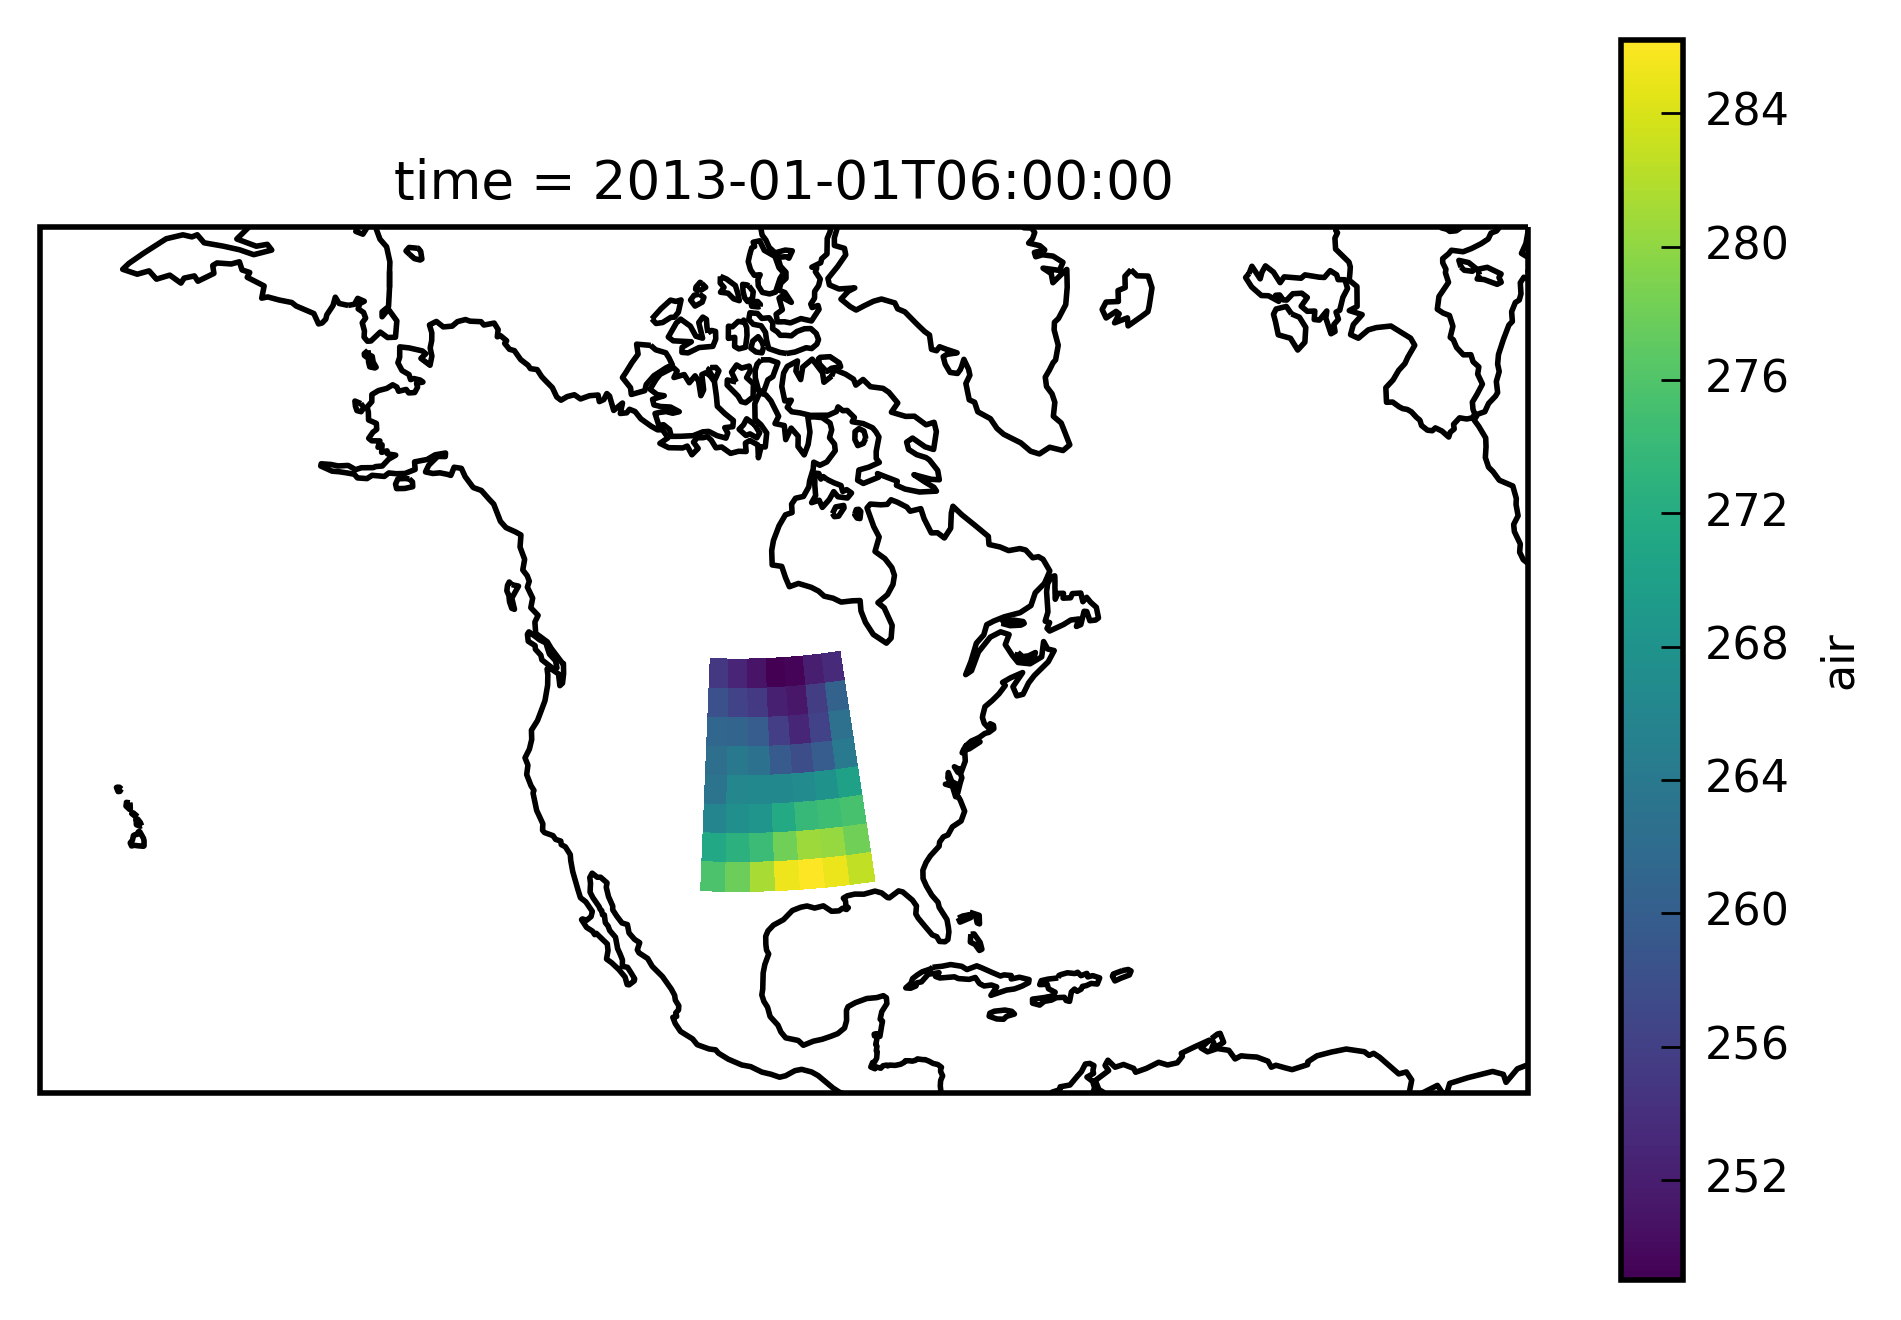

In [19]:
# choose a good projection for regional maps
proj=ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

airtemps_CNA.isel(time=1).air.plot.geocolormesh(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines();

Looks good - let's take the area average and plot the time series. (Note: you should use `cos(lat)` weights to correctly calculate an area average. Unfortunately this is not yet (as of version 0.7) implemented in xarray.) 

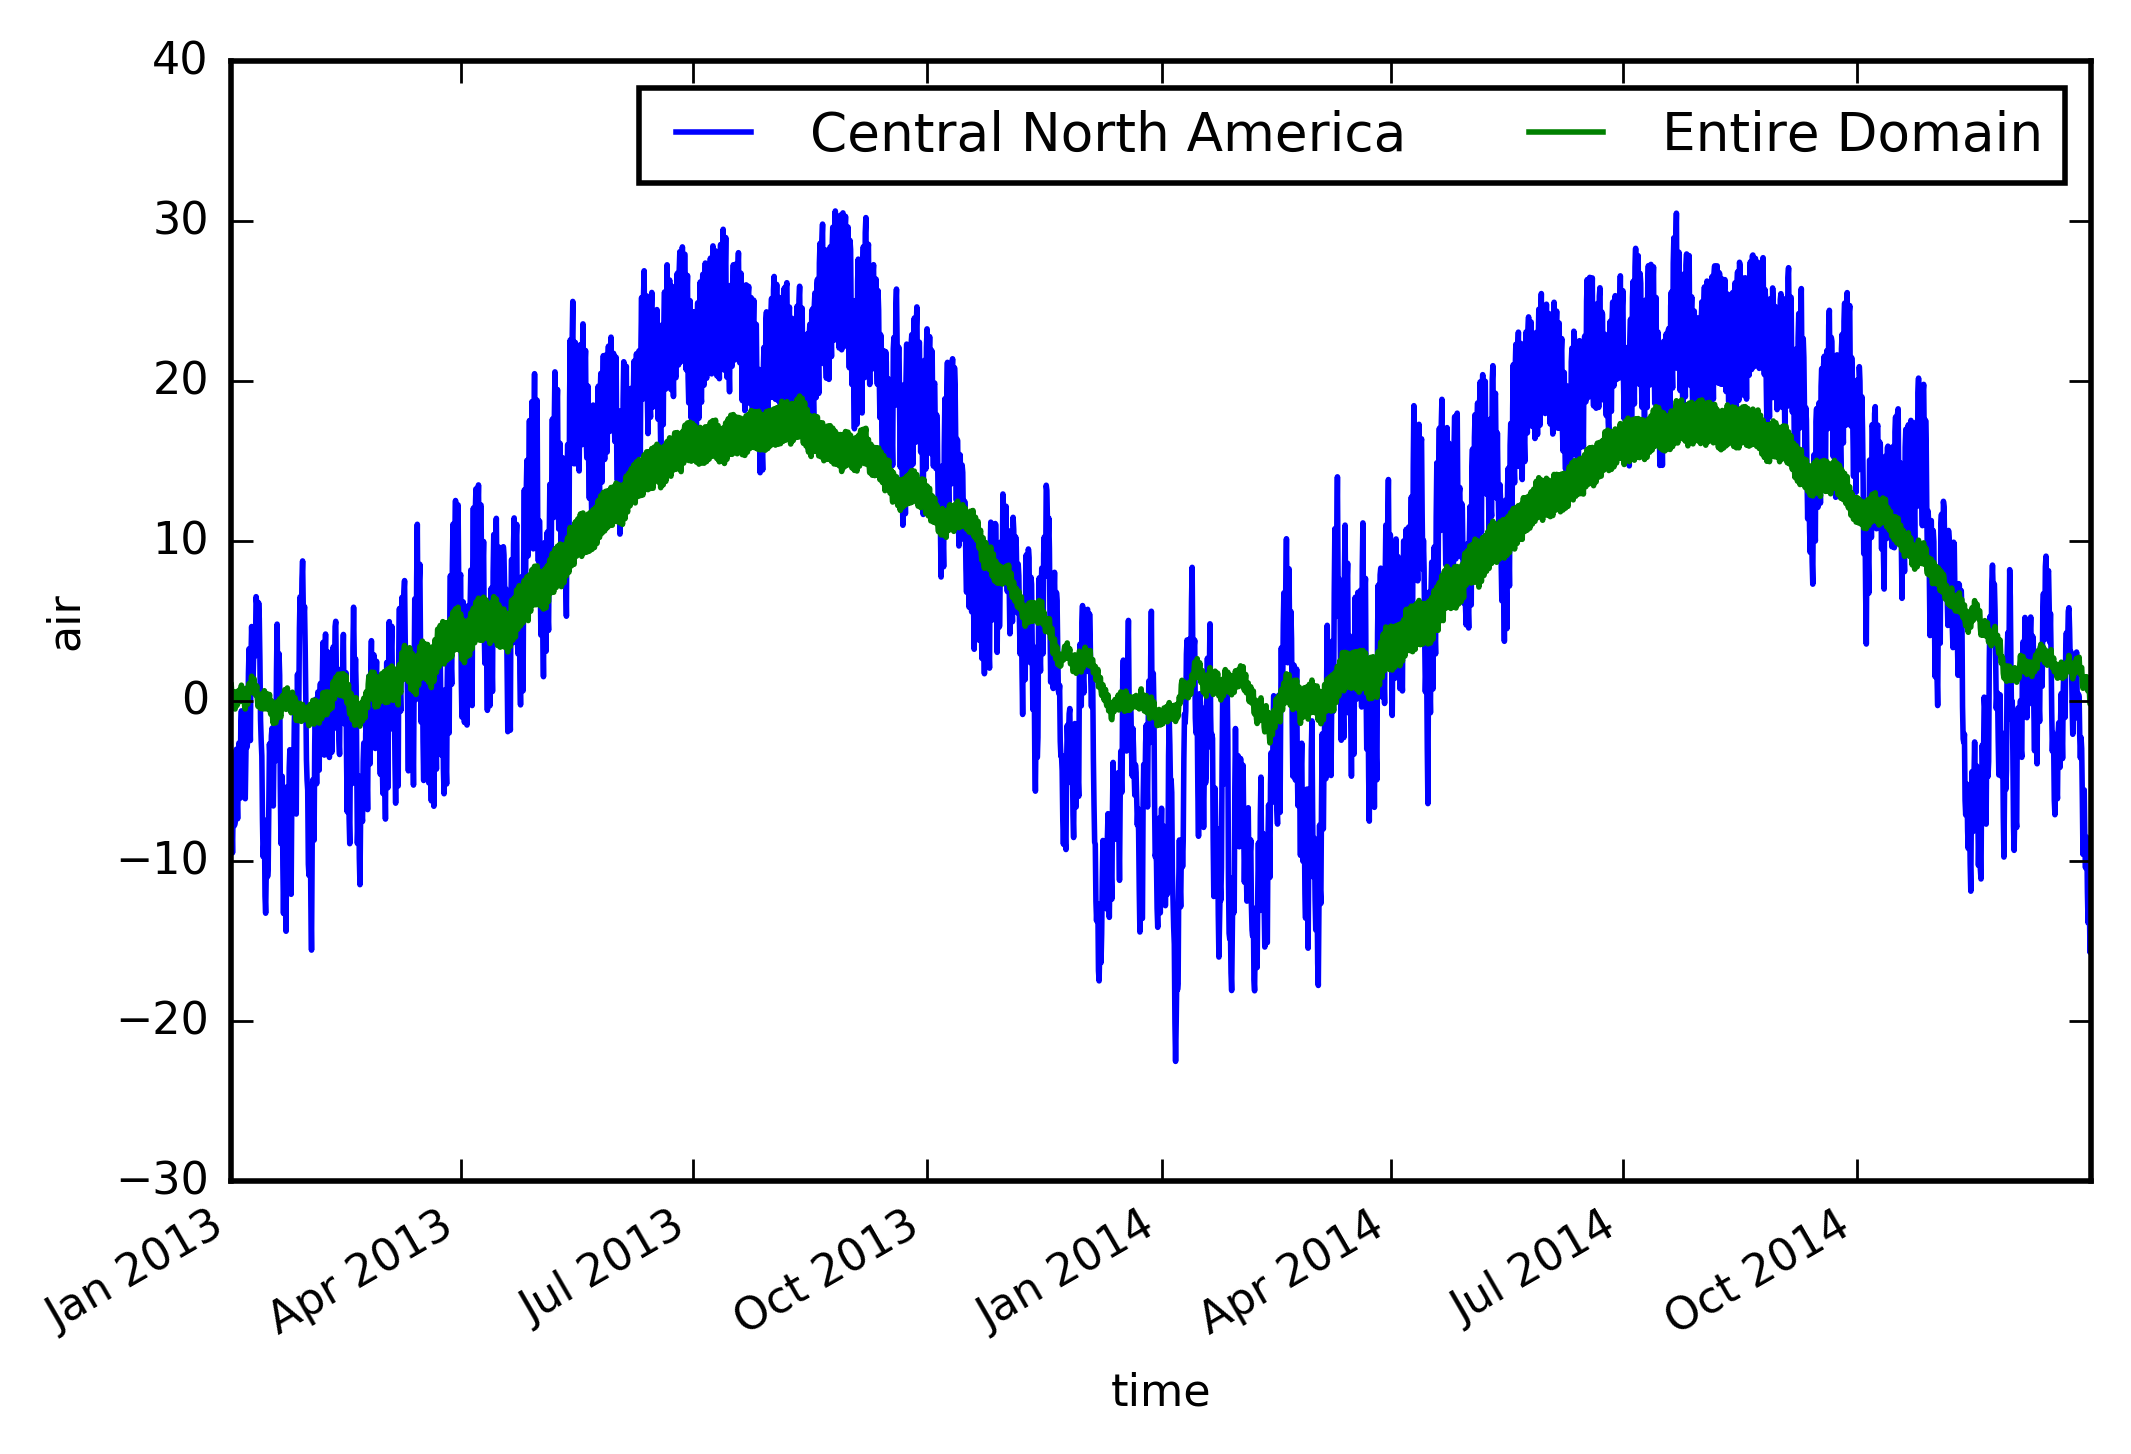

In [20]:
ts_airtemps_CNA = airtemps_CNA.mean(dim=('lat', 'lon')) - 273.15
ts_airtemps = airtemps.mean(dim=('lat', 'lon')) - 273.15

# and the line plot
ts_airtemps_CNA.air.plot.line(label='Central North America')
ts_airtemps.air.plot(label='Entire Domain')

plt.legend(ncol=2)
